In [456]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.fftpack import fftfreq, fft, ifft
from uncertainties import ufloat
from uncertainties import unumpy as unp
from sklearn.metrics import r2_score 

def get_dat_paths():
    current_dir = os.getcwd()
    root_dir_relative = ''
    root_dir = os.path.abspath(os.path.join(current_dir, root_dir_relative))

    dat_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.dat'):
                dat_paths.append(os.path.join(dirpath, filename))
    return dat_paths

dat_paths = get_dat_paths()

In [457]:
def get_data_from_path(path):
    # 读取文件内容
    with open(path, 'r', encoding='cp1252') as file:
        lines = file.readlines()

    distance = path.split('/')[-1]
    distance = float(distance.removesuffix('mm.dat').replace('-','.')) / 10.

    # 创建字典来存储参数
    parameters = {}

    # 逐行读取文件内容
    for line in lines:
        # 去除行首尾的空白符
        line = line.strip()
        # 忽略空行和注释行
        if not line or line.startswith('#'):
            continue
        # 如果行包含等号，则将其解析为键值对
        if '=' in line:
            key, value = line.split('=')
            parameters[key.strip()] = value.strip()

        # 读取数据表格
    data_start = False
    # data = []
    times, hfs, amps = [], [], []

    for line in lines:
        if line.startswith("Depth ["):
            data_start = True
            continue
        if data_start and line.strip():
            # data.append(line.strip().split())
            time, hf, amp = line.strip().split()
            times.append(float(time))
            hfs.append(float(hf))
            amps.append(float(amp))

    times = np.array(times)
    hfs = np.array(hfs)
    amps= np.array(amps)

    return times, hfs, amps, distance



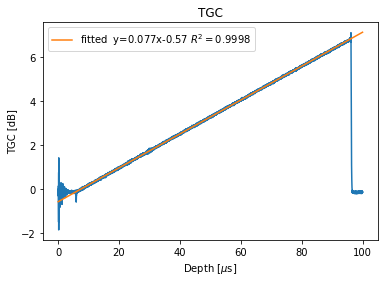

In [458]:
def get_tgc_from_path(path):
    # 读取文件内容
    with open(path, 'r', encoding='cp1252') as file:
        lines = file.readlines()

        times, tgcs = [], []
        for line in lines[1:]:
            if line.strip():
                # data.append(line.strip().split())
                time, tgc = line.strip().split()
                times.append(float(time))
                tgcs.append(float(tgc))

    times = np.array(times)
    tgcs = np.array(tgcs)

    return times, tgcs

times, tgcs = get_tgc_from_path('TGC.datfile')

plt.title('TGC')
plt.ylabel('TGC [dB]')
plt.xlabel(r'Depth [$\mu$s]')

plt.plot(times, tgcs)
mask = np.where((times > 20)&(times<80))
slope, intercept, rsq, _,_ = linregress(times[mask], tgcs[mask])
plt.plot(times, slope*times+intercept, label='fitted'+f'  y={slope:.3f}x{intercept:.2f}'+rf' $R^2={rsq:.4f}$')
def tgc(t):
    return slope*t+intercept

plt.legend()
# plt.savefig('TGC.png')

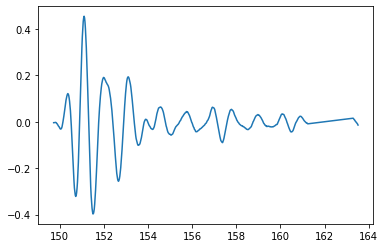

In [459]:
path = dat_paths[3]
times, hfs, amps, distance = get_data_from_path(path)

mask = np.where((times > 20)*(amps > 0.018))

echo_time = times[mask][0]

amplitude = max(amps[mask])

plt.plot(times[mask], hfs[mask])

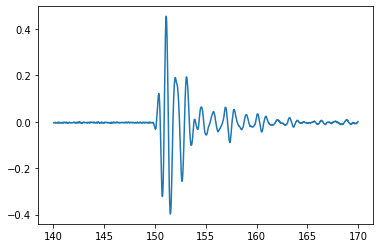

In [460]:
mask = np.where((times > 140)&(times < 170))
plt.plot(times[mask], hfs[mask])

1.0340226817878593

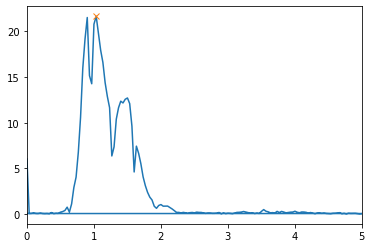

In [461]:
N = len(times[mask])
dt = np.average(np.diff(times[mask]))

xf = fftfreq(N,dt)
yf = fft(hfs[mask])

plt.plot(xf,np.abs(yf))
plt.plot(freq_peak :=xf[np.argmax(np.abs(yf))], np.max(np.abs(yf)),'x')
plt.xlim(0,5)

freq_peak

(-0.6, 0.6)

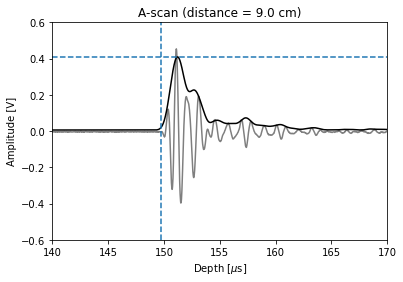

In [462]:
plt.plot(times,amps, color = 'black')
plt.plot(times,hfs, alpha=0.5, color = 'black')
plt.title(f'A-scan (distance = {distance:.1f} cm)')

plt.axvline(echo_time, ls = '--')
plt.axhline(amplitude, ls = '--')

# plt parameters for ascan plt
plt.xlabel(r'Depth [$\mu$s]')
plt.ylabel(r'Amplitude [V]')
# plt.grid()
plt.xlim(140,170)
plt.ylim(-0.6,0.6)
# end
# plt.savefig('Ascan.png')

In [463]:
echo_times = []
amplitudes = []
distances = []

for path in dat_paths:
    times, hfs, amps, distance = get_data_from_path(path)
    mask = np.where((times > 20)*(amps > 0.02))

    echo_time = times[mask][0]
    peak_time = times[mask][np.argmax(amps[mask])]
    amplitude = max(amps[mask])
    # / np.power(10,tgc(peak_time)/20)

    distances.append(distance)
    
    echo_times.append(echo_time)
    amplitudes.append(amplitude)

echo_times = np.array(echo_times)
amplitudes = np.array(amplitudes)
distances = np.array(distances)

In [464]:
np.sort(distances) # cm

array([ 0.576,  1.   ,  1.5  ,  2.   ,  2.5  ,  3.   ,  3.5  ,  4.   ,
        4.   ,  4.5  ,  5.   ,  5.5  ,  6.   ,  6.5  ,  7.   ,  7.5  ,
        8.   ,  8.5  ,  9.   ,  9.5  , 10.   ])

1481.6+/-1.5 m/s
-2.103+/-0.008


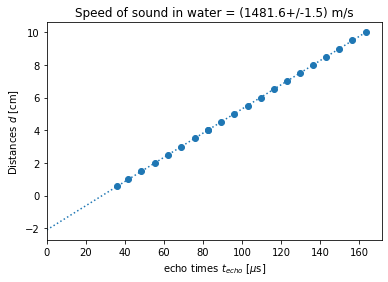

In [465]:
plt.scatter(echo_times, distances)
slope, intercept, r_value, p_value, std_err = linregress(echo_times, distances)
print(speed := 2* ufloat(slope,std_err) * 1e-2/1e-6, 'm/s')
print(ufloat(intercept,linregress(echo_times, distances).intercept_stderr))
distances -= intercept
distances = 2 * distances

plt.xlabel(r'echo times $t_{echo}$ [$\mu$s]')
plt.ylabel(r'Distances $d$ [cm]')

plt.plot(x:=np.array([0,max(echo_times)]), slope*x + intercept, ls='dotted', label = 'fitted')
plt.xlim(0)

plt.title(f'Speed of sound in water = ({speed}) m/s')

plt.savefig('PHY04_speed.png')

(0.0, 25.149034440534432)

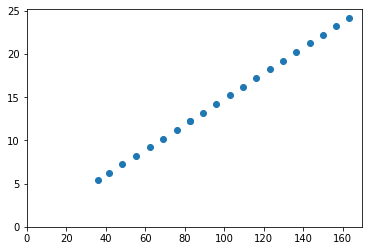

In [466]:
plt.scatter(echo_times, distances)
plt.xlim(0)
plt.ylim(0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


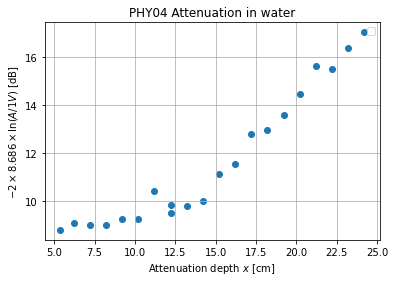

In [467]:
plt.scatter(xs := distances,ys := -2 * 8.686 * np.log(amplitudes))
plt.xlabel(r'Attenuation depth $x$ [cm]')
plt.ylabel(r'$-2\times 8.686 \times \ln (A/1V)$ [dB]')

slope, intercept, r_value, p_value, std_err = linregress(xs,ys)
alpha = ufloat(slope, std_err)
# plt.plot(xs, slope * xs + intercept, label = rf'$\alpha=${alpha} [dB/cm]; $R^2=${r_value:.4f}')
plt.legend()
plt.grid()
plt.title('PHY04 Attenuation in water')

plt.savefig('PHY04.png')

$x = 2(d+d_0)$

\begin{equation}
I=I_0 e^{-\alpha x}
\end{equation}
$I\propto A^2$
\begin{equation}
2\ln\left(\frac{A}{A_0}\right) [{\rm Np}] = -\alpha x
\end{equation}

\begin{equation}
2\times 8.686 \times \ln\left(\frac{A}{A_0}\right) [{\rm dB}] = -\alpha x
\end{equation}

\begin{equation}
\ln\left(\frac{A}{1V}\right)=-\frac{\alpha}{2} x + \ln\left(\frac{A_0}{1V}\right)
\end{equation}


In [468]:
def value_compare(exp_value, th_value_text, unit = '', latex = False):
    th_value = float(th_value_text)
    error = ((exp_value - th_value)/th_value ).n * 100
    if latex:
        exp_value_text = str(exp_value).replace('+/-', '(') + ')'
    else:
        exp_value_text = str(exp_value)
    # th_value_text = str(format(th_val e,'e')).replace('+/-', '\pm')
    output = '\SI{'+ exp_value_text + '}{' + unit + '}，與理論值\SI{' + th_value_text + '}{' + unit + '}誤差為\SI{' + f'{error: .1f}' + '}{\percent}'
    if latex:
        print(output)
    else:
        print(output.replace('\SI','').replace('{','').replace('}','').replace('\percent','%'))

In [469]:
alpha = ufloat(slope,std_err)
value_compare(alpha, '0.02', 'dB/cm')

0.456+/-0.033dB/cm，與理論值0.02dB/cm誤差為 2180.1%


当声波在液体中传播时，由于吸收(能量转换)、反射、散射或声场的几何形状而衰减。对于整个衰减:

对于许多液体，反射和散射可以忽略不计。声场几何形状的影响可以通过在水中进行比较测量来估计，在水中，低频吸收可以忽略不计。对于声波强度的减弱，适用以下一般衰减定律:

https://jontallen.ece.illinois.edu/uploads/473.F18/Lectures/Chapter_8.pdf

25e-13 Np s^2 /m
25*8.686e-13 dB  /m Hz^2 * (10^6Hz)^2


In [470]:
alpha / 8.686

0.052500847989671556+/-0.0037882159000779086

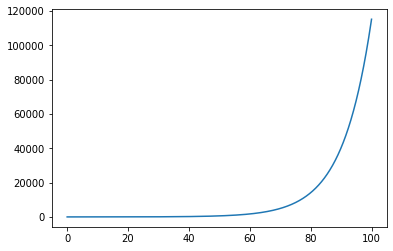

In [471]:
plt.plot(times, np.power(10,tgc(times)/10))